# Predicting the survivors of the titanic

#### [Problem](#problem)
#### [Import Packages](#import)
#### [Load the data](#load)
#### [Information about the data](#data_info)
#### [Exploratory Data Analysis](#eda)
##### [General descriptives](#general_descriptives)
###### [Null values: Age and Cabin](#age_cabin_null)
###### [Unique values](#unique_values)
##### [Survival rate by Sex](#male_female_survival)
##### [Survival rate by social class](#class_survival)
##### [Correlations](#correlation)
##### [Frequency distributions](#freq_distribution)
##### [Summary of EDA](#summary_eda)
### [Data Cleaning and Pre-processing](#clean)
#### [Drop columns](#drop_columns)
#### [Dealing with the missing values](#missing_values)
#### [Scaling the data](#scaling)
##### [Joining the scaled data with the categorical data](#joining)
#### [One-hot encoding](#one_hot)


## Problem <a id='problem' ><a/>
* Predict which people survived the Titanic given a set of variables.
* The output will be a prediction of 1 or 0, for survived and did not survive respectively.

## Import packages <a id='import' ><a/>

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Load the data <a id='load' ><a/>

* Two _.csv_ files have been provided for this problem.
* _train.csv_ contains predictor and target data and will be used to trained on. Once we have a final model we will use _test.csv_...
* _test.csv_ contains only the features and is a dataset for our final model to be truly tested on! The accuracy of the predictions made by the chosen model will be assessed by uploading to kaggle (or finding the answer sheet online!)

In [191]:
# load the training data
raw_data = pd.read_csv('train.csv')

# create a copy of the raw data so that we always have the raw data to go back to if need be
df = raw_data.copy()

# check out the first 5 rows of data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* A quick view of the data tells me that I'll need to transform the _Sex_ and _Embarked_ variables into numerical data before exploring correlations.
* I'm not sure how useful the _Ticket_ column will be so this may be dropped later on, similarly for the Name. 

### Information about the data <a id='data_info' ><a/>

The following information has been provided about the variables:
* **Pclass**:  A proxy for socio-economic status (SES) 1st = Upper, 2nd = Middle, 3rd = Lower
* **Age**: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5
* **SibSp**:  Number of Siblings/Spouses Aboard. The dataset defines family relations in this way: _Sibling_ = brother, sister, stepbrother, stepsister. _Spouse_ = husband, wife (mistresses and fiancés were ignored)
* **Parch**: Number of Parents/Children Aboard, The dataset defines family relations in this way: _Parent_ = mother, father. _Child_ = daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore _parch_ = 0 for them.

## Exploratory Data Analysis <a id='eda' ><a/>

Before beginning with data cleaning, pre-processing etc. I want to understand the data to help determine:
* Which variables to keep (whether because they are useful, uselss, or have too many outliers or missing values.
* If there is a possibility for feature engineering.
* If any transformations need to be conducted on the data.

To help achieve this I will look at:
1. **General descriptives**: to get an idea of counts, means, median and modes. 
2. **Missing/Null values**: some machine learning algorithms don't work well with missing values, so if there are missing values I will need to decide how to handle them (delete the entire row, impute with median etc.)
3. **Frequency distributions**: to get an idea of if any variables contain outliers.
4. **Correlations**: to assess if there are some variables that are very important (which may influence whether they are kept or not if, for example, the very important variable has a lot of missing values). 

### General descriptives and investigating variables <a id='general_descriptives' ><a/>

In [192]:
# get shape of data to understand how many rows and columns there are
df.shape

(891, 12)

In [193]:
# get general descriptives for the numerical data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Notes
* The majority of the numerical columns contain 891 non-null values.
* **Age** varies from newborn to 80 years old, with 75% of the dataset <38 years old.
* The **Fare** variable would appear to have outliers given the difference between the max value and the mean.
* There might be potential to combine **SibSp** and **Parch** to make a '_Family_size_' variable - perhaps if you were part of a larger or smaller family you were more or less likely to survive.
* The data will need to be scaled - WHY?

### Age and Cabin null values <a id='age_cabin_null' ><a/>

In [194]:
# check to see how many null values there are
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* _Age_ and _Cabin_ have a large number of null values.
* _Embarked_ has only two null values so this is not an issue, but will still need to be taken into consideration when deciding the logic behind dealing with missing values.
* Let's get a bit more information about the percentage of the values that are null

In [195]:
# what percentage of Age and Cabin's values are null values
print(f"Percentage of Age values that are null: {(df['Age'].isnull().sum()) / (df['PassengerId'].count()) * 100}")
print(f"Percentage of Cabin values that are null: {(df['Cabin'].isnull().sum()) / (df['PassengerId'].count()) * 100}")

Percentage of Age values that are null: 19.865319865319865
Percentage of Cabin values that are null: 77.10437710437711


In [196]:
# see how many total and unique values there are in the Cabin variable
print(f"Cabin total values: {df['Cabin'].count()}")
print(f"Cabin unique values: {df['Cabin'].nunique()}")
print(f"Percentage of all Cabin values that are unique: {(df['Cabin'].nunique() / df['Cabin'].count()) * 100}%")

Cabin total values: 204
Cabin unique values: 147
Percentage of all Cabin values that are unique: 72.05882352941177%


* Due to the number of null values it was likely that _Cabin_ would be dropped. 
* Furthermore, due to the high percentage of unqiue values (which makes sense given it is essentially a room number) it is unlikely that a pattern would be found? Unless certain sections of ship had more fatalities, but this would also ssume that everyone was in their room at the time of crash.
* _Age_ has (just) less than 20% null values, however I have a feeling that _Age_ will be a key variable so it is unlikely that this feature will be dropped.

### Unique Values <a id='unique_values' ><a/>

It might be worthwhile knowing how many unqiue values are in some other variables. If the categorical data variables have lots of unique values then perhaps they might not be worth keeping? 

In [197]:
# how many unique values are there in each variable
for i in df:
    print(f"""
{i} total: {df[i].count()}
{i} unique: {df[i].nunique()}
Percentage of values that are unique: {(df[i].nunique()/df[i].count())*100} """)


PassengerId total: 891
PassengerId unique: 891
Percentage of values that are unique: 100.0 

Survived total: 891
Survived unique: 2
Percentage of values that are unique: 0.22446689113355783 

Pclass total: 891
Pclass unique: 3
Percentage of values that are unique: 0.33670033670033667 

Name total: 891
Name unique: 891
Percentage of values that are unique: 100.0 

Sex total: 891
Sex unique: 2
Percentage of values that are unique: 0.22446689113355783 

Age total: 714
Age unique: 88
Percentage of values that are unique: 12.324929971988796 

SibSp total: 891
SibSp unique: 7
Percentage of values that are unique: 0.7856341189674524 

Parch total: 891
Parch unique: 7
Percentage of values that are unique: 0.7856341189674524 

Ticket total: 891
Ticket unique: 681
Percentage of values that are unique: 76.43097643097643 

Fare total: 891
Fare unique: 248
Percentage of values that are unique: 27.83389450056117 

Cabin total: 204
Cabin unique: 147
Percentage of values that are unique: 72.058823529

We already know that _Cabin_ had a high percentage of unique values, we now see that _Ticket_ does as well (76%). I therefore wonder if _Ticket_ will provide much value.

### Survival rate by Sex <a id='male_female_survival' ><a/>

I want to explore if _Sex_ appeared to influence survival...

In [198]:
# how many males and females are in the dataset
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [199]:
# did more males or females survive?
df.groupby(['Sex', 'Survived']).count()

PassengerId  Pclass  Name  Age  SibSp  Parch  Ticket  Fare  \
Sex    Survived                                                               
female 0                  81      81    81   64     81     81      81    81   
       1                 233     233   233  197    233    233     233   233   
male   0                 468     468   468  360    468    468     468   468   
       1                 109     109   109   93    109    109     109   109   

                 Cabin  Embarked  
Sex    Survived                   
female 0             6        81  
       1            91       231  
male   0            62       468  
       1            45       109

The above output tells us more females survived than males. The counts tell us that there were many more males on board so I am interested to see the percentage breakdown...

In [200]:
# get the percentage breakdown of male and female survival
# this should be read as x% of females survived i.e. if 100 females were aboard and 10 survived then the % returned 
# will be 10
print(f"Female survival %: {sum((df.Sex == 'female') & (df.Survived == 1)) / sum(df.Sex == 'female')*100}")
print(f"Male survival %: {sum((df.Sex == 'male') & (df.Survived == 1)) / sum(df.Sex == 'male')*100}")

Female survival %: 74.20382165605095
Male survival %: 18.890814558058924


* Approximately 3 out every 4 females survived but only ~1 in every 5 males did.
* It would seem that _Sex_ is a very important variable in determining survival.

### Survival rate by class <a id='class_survival' ><a/>

We know that _Pclass_ variable is a proxy for socio-economic status, with the following definitions: 1st = Upper, 2nd = Middle, 3rd = Lower so it would be interesting to see if there were any differences in survival rates.

Also - as the social classes are labelled 1, 2 and 3 there is no need to map or one-hot encode.

In [201]:
# check the unique values in Pclass to make sure we capture all classes
df['Pclass'].unique()

array([3, 1, 2])

As expected the output is the numbers 1, 2, and 3, representing the upper, middle, and lower socio-economic status groups respectively.

In [202]:
# get a view of the counts of those who survived by Pclass
df.groupby(['Pclass', 'Survived']).count()

PassengerId  Name  Sex  Age  SibSp  Parch  Ticket  Fare  \
Pclass Survived                                                            
1      0                  80    80   80   64     80     80      80    80   
       1                 136   136  136  122    136    136     136   136   
2      0                  97    97   97   90     97     97      97    97   
       1                  87    87   87   83     87     87      87    87   
3      0                 372   372  372  270    372    372     372   372   
       1                 119   119  119   85    119    119     119   119   

                 Cabin  Embarked  
Pclass Survived                   
1      0            59        80  
       1           117       134  
2      0             3        97  
       1            13        87  
3      0             6       372  
       1             6       119

The output above shows that 372 people in the lower class died; I'm interested to see what percentge this is of all the people who died and what percentage of all people aboard the ship were in the lower class...

In [203]:
# the output above shows us that 372 people in class 3 died; what % is this of all those who died
(df.query('Pclass==3 & Survived==0')['Survived'].count()) / (df.query('Survived==0')['Survived'].count()) * 100

67.75956284153006

In [204]:
# what % of all of those aboard the ship were classified as lower class
(df.query('Pclass==3')['Pclass'].count()) / (df.query('Pclass')['Pclass'].count()) * 100

55.106621773288445

The outputs show us that the majority (67%) of those who died  were in the lower class, but the lower class only made up 55% of the dataset. I am therefore interested to see what the survival % for each socio-econiomic status looks like to assess whether proportionally more of one class survived than the others...

In [205]:
# get the percentage breakdown of survival by socio-economic status
print(f"Upper class survival %: {sum((df.Pclass == 1) & (df.Survived == 1)) / sum(df.Pclass == 1)*100}")
print(f"Middle class survival %: {sum((df.Pclass == 2) & (df.Survived == 1)) / sum(df.Pclass == 2)*100}")
print(f"Lower class survival %: {sum((df.Pclass == 3) & (df.Survived == 1)) / sum(df.Pclass == 3)*100}")

Upper class survival %: 62.96296296296296
Middle class survival %: 47.28260869565217
Lower class survival %: 24.236252545824847


In [206]:
# quick challenge try do the above in a for loop
for i in df['Pclass'].unique():
    print(f"SES class {i} survival %: {sum((df.Pclass == i) & (df.Survived == 1)) / sum(df.Pclass == i)*100}")

SES class 3 survival %: 24.236252545824847
SES class 1 survival %: 62.96296296296296
SES class 2 survival %: 47.28260869565217


* The survival rate for the upper class was 2.5 times greater than that of the lower class.
* Middle class survival was 2 times that of the lower class but less than the upper class.
* This would suggest that socio-economic status also had an important bearing on who survived.

## Correlations <a id='correlation' ><a/>

Let's see if there are correlations between the variables...

In [207]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Predicting survival is the ultimate goal so it makes sense to check what the correlations are with '_Survived_'...

In [208]:
# get a quicker view on the numerical variables' correlations with Survived
corr_matrix = df.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

* _Pandas_ uses Pearson's r correlation coefficient.
* The output shows that _Fare_ has a slightly positive correlation with survival, and _Pclass_ has a negative correlation. 
* The negative correlation with _Pclass_ makes sense when we consider the percentges found earlier regarding social class and survival. 
* As the social class value in the data goes up (1 = highest socio-economic status and 3 = lowest) the chance of survival decreases. i.e., the lower the socio-economic status the less chance of survival.
* The positive association between _Fare_ and survival also makes sense given previous findings; one would assume that the higher classes paid more expensive fares. This is also seen in the correlation matrix with a strong negative correlation (-0.55) between _Fare_ and _Pclass_, meaning as the fare increased, the social class value went down which, again, given that 1 = highest social class and 3 = lowest, in fact means that the higher fares are associated with the highest socio-economic status.

In [209]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### Frequency distributions <a id='freq_distribution' ><a/>

* Is the data normally distributed? (This will affect scaling.)
* Are there any outliers? If so, do I keep them or remove them? Why?



array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

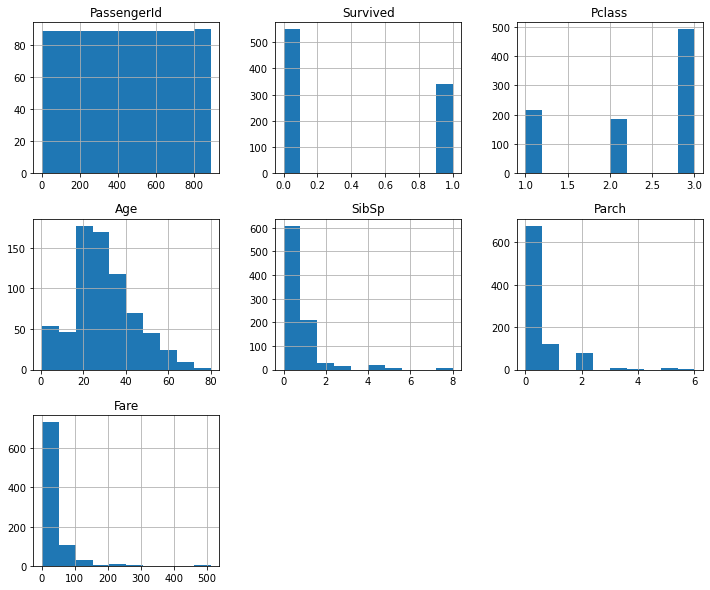

In [210]:
# show histograms of the numerical variables
df.hist(figsize=(12,10))

* The output shows that _Fare_ is heavily skewed to the right and so will likely have outliers greater than 1.5 times the interquartile range.
* Similarly, _SibSp_ is also skewed to the right, as is _Parch_
* _Age_ is also skewed to the right but not as heavily as Fare.

**What does this tell me?**
* There are outliers in several of the variables and I will need to decide how to deal with them.
* As these variables do not follow a normal distribution I will need to investigate if this effects anything regarding how the algorithm handles the data. I remember that some linear regression models have assumptions of a normal distribution, if this is the case for Logistic regression, decision trees and/or Xtra Boost then this will effect how the data is cleaned/pre-processed.

### Summary of EDA <a id='summary_eda' ><a/>
* _Cabin_ will be dropped. 
* _Fare_ and _Pclass_ are correlated with Survival and so are both important variables.
* _Age_ has 177, and _Embarked_ has 2, null values and I will need to decide how to handle these.
* _Fare_, _SibSp_, and _Parch_ are skewed to the right and I need to figure how/if this effects how I should treat the data before it is fed to the training algorithm.
* Figure out if/why the data needs to be scaled?

## Next steps

- - - - 
Drop columns, scale data, one-hot encode categoricals, feature engineering.

# Data Cleaning and Pre-Processing <a id='clean' ><a/>

### Dropping columns <a id='drop_columns' ><a/>

**Why do we need/want to drop columns?**

I want to only feed the algorithm data that is meaningfully related to survival. Feeding the algorithm data that is not useful could interfere with its search for underlying patterns in the data.

In [212]:
# drop cabin and ticket columns from the dataframe
df = df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Dealing with the missing values <a id='missing_values' ><a/>

* Age has 177 missing values. 
* The dataset only contains 891 values and I want as much data as possible to train the algorithm on, so I am reluctant to drop the rows with missing values.
* There are several options to deal with missing values:
    * Drop the column - don't want to do this
    * Drop the rows with the missing values - don't really want to do this
    * Use _SimpleImputer()_ to generate a value (mean, median etc.) for the missing values. **(Is this the type of thing done by the machine learning engineers?? and i should jsut be using _fillna_??)**
    * Calculate the median value and then use _fillna_ to populate the missing values.


In [213]:
# get a list of the null values for validation after fillna is used
df[df['Age'].isnull()].index.tolist()

[5,
 17,
 19,
 26,
 28,
 29,
 31,
 32,
 36,
 42,
 45,
 46,
 47,
 48,
 55,
 64,
 65,
 76,
 77,
 82,
 87,
 95,
 101,
 107,
 109,
 121,
 126,
 128,
 140,
 154,
 158,
 159,
 166,
 168,
 176,
 180,
 181,
 185,
 186,
 196,
 198,
 201,
 214,
 223,
 229,
 235,
 240,
 241,
 250,
 256,
 260,
 264,
 270,
 274,
 277,
 284,
 295,
 298,
 300,
 301,
 303,
 304,
 306,
 324,
 330,
 334,
 335,
 347,
 351,
 354,
 358,
 359,
 364,
 367,
 368,
 375,
 384,
 388,
 409,
 410,
 411,
 413,
 415,
 420,
 425,
 428,
 431,
 444,
 451,
 454,
 457,
 459,
 464,
 466,
 468,
 470,
 475,
 481,
 485,
 490,
 495,
 497,
 502,
 507,
 511,
 517,
 522,
 524,
 527,
 531,
 533,
 538,
 547,
 552,
 557,
 560,
 563,
 564,
 568,
 573,
 578,
 584,
 589,
 593,
 596,
 598,
 601,
 602,
 611,
 612,
 613,
 629,
 633,
 639,
 643,
 648,
 650,
 653,
 656,
 667,
 669,
 674,
 680,
 692,
 697,
 709,
 711,
 718,
 727,
 732,
 738,
 739,
 740,
 760,
 766,
 768,
 773,
 776,
 778,
 783,
 790,
 792,
 793,
 815,
 825,
 826,
 828,
 832,
 837,
 839,
 84

In [214]:
# check the length of the above - it should be 177
len(df[df['Age'].isnull()].index.tolist())

177

In [215]:
# fill the missing Age values with the median (use the median to try to negate the infuence of outliers)
# fill the 2 missing Embarked values with the most commonly occurring category
df = df.fillna({'Age': df['Age'].median(),
                'Embarked': df['Embarked'].mode()})

In [216]:
# our index list of missing values showed that index 5 had a missing value for Age so it should now be filled with 28
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,28.0,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


## Scaling the data <a id='scaling' ><a/>

* Data is scaled to bring the data points closer together which allows the machine learning algorithm to be trained quicker and more accurately.
* Normalization appears to be the preferred method when the data doesn't follow a normal distribution (the frequency distribution graphs show that our numerical data doesn't follow a normal distribution)
* I'll use _MinMaxScaler()_ to scale the numerical data from 0 to 1.

In [217]:
# create an instance of MinMax scaler - this will use normalization and will scale the data between 0 and 1
scaler = MinMaxScaler()

I only want to scale the numerical data so I will separate the numerical and catefgorical columns. The plan is then to join the scaled data with the categorical columns data to create a 'new' dataframe.

Let's create a list of the numerical colums to feed to the scaler...

In [219]:
# create list of numerical column titles
numerical_columns = ['Age', 'SibSp','Parch', 'Fare']
# create a list of categorical columns titles
categorical_columns = ['Survived', 'Pclass', 'Sex', 'Embarked']

Now I will fit and transform the numerical variables. 'Fitting' finds the minimum and maximum which is then used during the transform phase where the raw data is transformed into our new scale of 0-1.

In [220]:
# scale the numerical columns in the dataframe and store in df_scaled variable
# this should return a numpy array
df_scaled = scaler.fit_transform(df[numerical_columns].to_numpy())

The output of the above is a numpy array, I need to get this back into dataframe format...

In [221]:
# create a dataframe from this numpy array and label the columns
df_scaled = pd.DataFrame(df_scaled, columns=numerical_columns)

#  check the new dataframe
df_scaled.head()

#### Joining the scaled data with the categorical data <a id='joining' ><a/>

In [223]:
# join the scaled data dataframe with the categorical variables, the join should join based on the index so the rows should
# all align 
df_scaled = df_scaled.join(df[categorical_columns])
# check the new dataframe
df_scaled.head()

,Age,SibSp,Parch,Fare,Survived,Pclass,Sex,Embarked
0,0.271174,0.125,0.0,0.014151,0,3,male,S
1,0.472229,0.125,0.0,0.139136,1,1,female,C
2,0.321438,0.000,0.0,0.015469,1,3,female,S
3,0.434531,0.125,0.0,0.103644,1,1,female,S
4,0.434531,0.000,0.0,0.015713,0,3,male,S


In [226]:
# reorder the columns so Survived is at the end
columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex',
       'Embarked','Survived']
df_scaled = df_scaled[columns]
df_scaled.head()

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Survived
0,0.271174,0.125,0.0,0.014151,3,male,S,0
1,0.472229,0.125,0.0,0.139136,1,female,C,1
2,0.321438,0.000,0.0,0.015469,3,female,S,1
3,0.434531,0.125,0.0,0.103644,1,female,S,1
4,0.434531,0.000,0.0,0.015713,3,male,S,0


### Scaling categories represented as numbers?
Do I need to scale, or do anything to _Pclass_ whose values are 1,2,3 but these are representative of categories??


Seems the answer to this is to one-hot encode categorical variables and they will then be on the same scale anyway..



### One-hot encoding the categorical variables <a id='one_hot' ><a/>

We have he categorical variables _Sex_ and _Embarked_ that need to be in numerical format for our machine learning algorithm. 

As the variables are not ordinal data it would seem that one-hot encoding is the preferred method...

In [227]:
# create an instance of one-hot encoder
cat_encoder = OneHotEncoder()

In [ ]:
# perform the encoding (fit) and then transform the dataset
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# check the ouput
housing_cat_1hot

# convert to a 2D array
housing_cat_1hot.toarray()
# we can also get a list of categories wit the encoder's categories_
cat_encoder.categories_